In [5]:
import sys
sys.path.append("../../BayesFlow")
sys.path.append("../")

import os
if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "torch"

import numpy as np
import pickle

import keras
import seaborn as sns

import matplotlib.pyplot as plt


parent_dir = '/home/administrator/Documents/BF-LIGHT'



In [6]:
import bayesflow as bf
from dmc import DMC, dmc_helpers

os.getcwd()

'/home/administrator/Documents/BF-LIGHT/playgrounds'

In [ ]:
network_name = 'dmc_optimized_updated_priors'

model_specs_path = parent_dir + '/model_specs/model_specs_' + network_name + '.pickle'
with open(model_specs_path, 'rb') as file:
    model_specs = pickle.load(file)

In [ ]:
# simulator = DMC(
#     prior_means=np.array([16., 111., 0.5, 322., 75.]), 
#     prior_sds=np.array([10., 47., 0.13, 40., 23.]),
#     tmax=1500
# )

network_dir = parent_dir + "/data/training_checkpoints/" + network_name + '.keras'

# network_dir = parent_dir + "/data/optuna_checkpoints/network_0.02_0.0_2_10_16_128.keras"

print(os.path.exists(network_dir))

True


In [11]:
approximator = keras.saving.load_model(network_dir)


/home/administrator/miniforge3/envs/bf_new/lib/python3.11/site-packages/keras/src/saving/serialization_lib.py:734: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)


In [12]:
import pandas as pd

narrow_data = pd.read_csv('../data/model_data/experiment_data_narrow.csv')
wide_data = pd.read_csv('../data/model_data/experiment_data_wide.csv')

empirical_data = pd.concat([narrow_data, wide_data])

In [13]:
samples_narrow=dmc_helpers.fit_empirical_data(narrow_data, approximator)

samples_narrow["spacing"]="narrow"

samples_wide=dmc_helpers.fit_empirical_data(wide_data, approximator)

samples_wide["spacing"]="wide"

samples_complete=pd.concat((samples_wide, samples_narrow))

In [14]:
parts=samples_complete["participant"].unique()

samples_complete

A         tau      mu_c        mu_r           b  participant  \
0     8.382860  132.808502  0.587058  295.340027   76.175316         1108   
1     8.142234   99.833328  0.640831  293.294373   80.721336         1108   
2     3.000730   72.912918  0.616422  294.224609   76.830963         1108   
3     7.897243   87.306534  0.664059  297.396423   80.465218         1108   
4     6.358157  115.384888  0.593316  296.049713   78.177002         1108   
..         ...         ...       ...         ...         ...          ...   
995  34.251522  217.094757  0.816411  318.317505  113.300484       337788   
996  14.371937  148.521942  0.736191  320.818848  100.672508       337788   
997  19.292097  180.686020  0.715486  321.874817  101.297752       337788   
998  12.229984  175.241745  0.692069  324.517853   94.479073       337788   
999  16.689814  148.867279  0.702026  322.814301  100.172440       337788   

     sampling_time spacing  
0         0.060564    wide  
1         0.060564    wide  
2         0.060564    wide  
3         0.060564    wide  
4         0.060564    wide  
..             ...     ...  
995       0.067783  narrow  
996       0.067783  narrow  
997       0.067783  narrow  
998       0.067783  narrow  
999       0.067783  narrow  

[134000 rows x 8 columns]

## Posterior Predictive Check

In [15]:
empirical_accuracies_congruent = []
empirical_accuracies_incongruent = []

resimulated_accuracies_congruent = []
resimulated_accuracies_incongruent = []


/tmp/ipykernel_26496/1093723017.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1,2, figsize=(10,3))


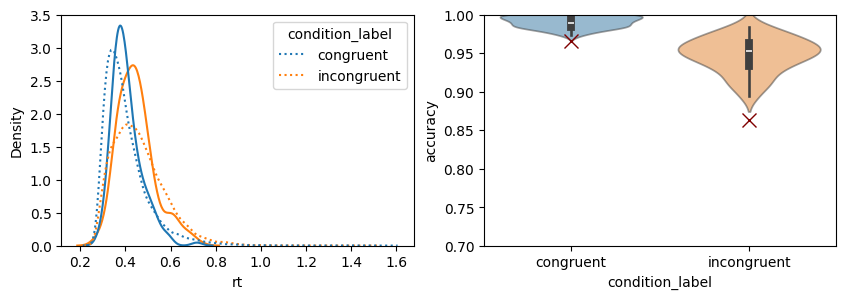

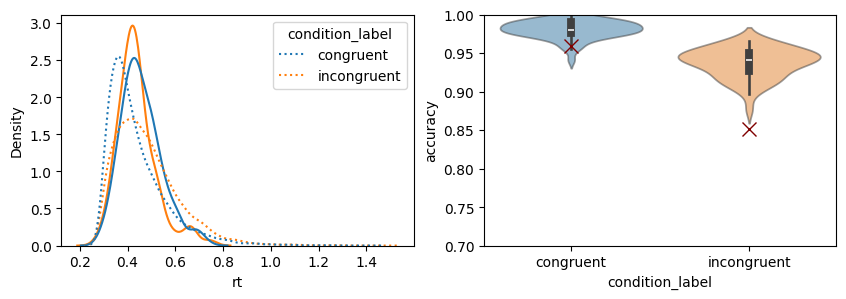

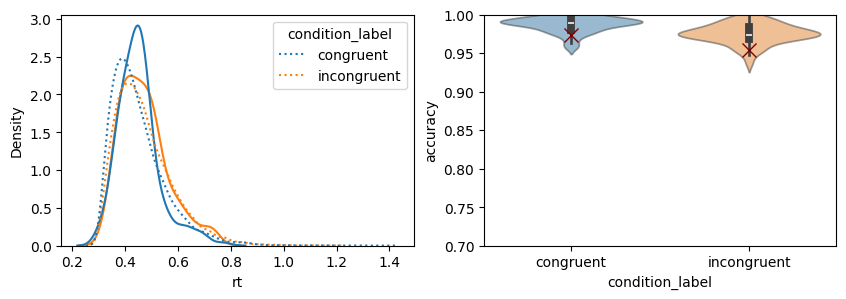

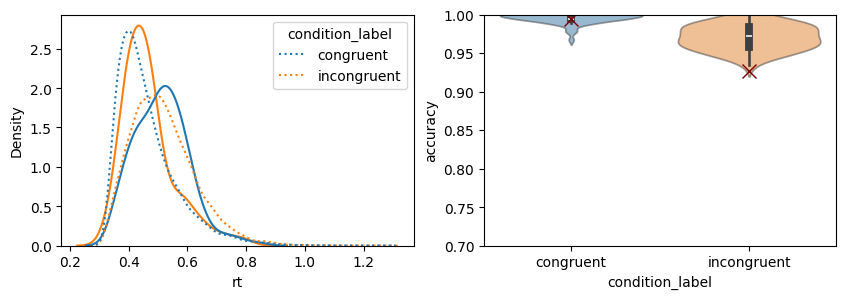

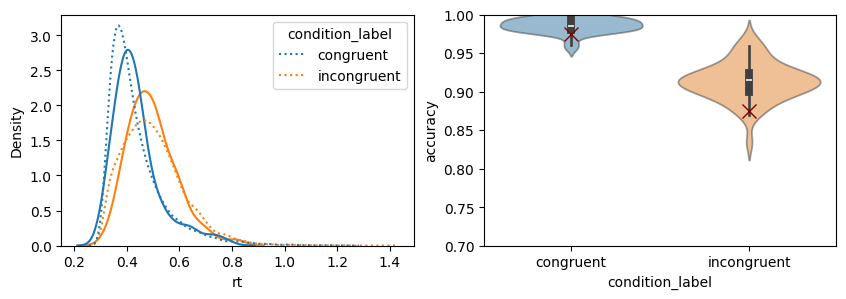

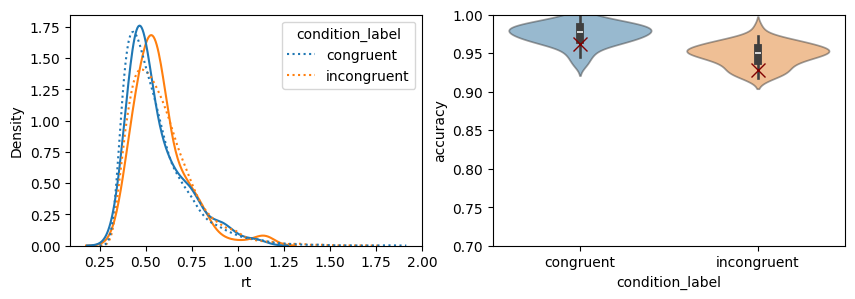

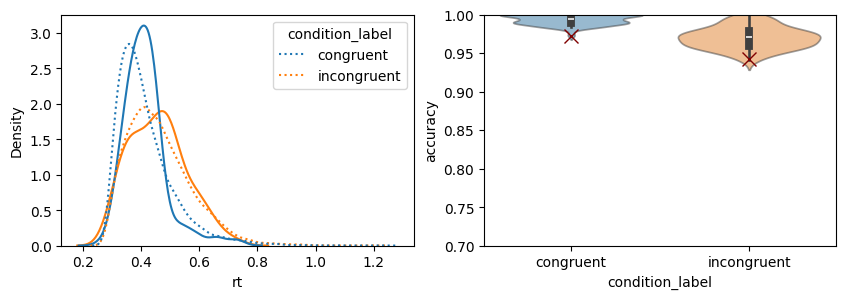

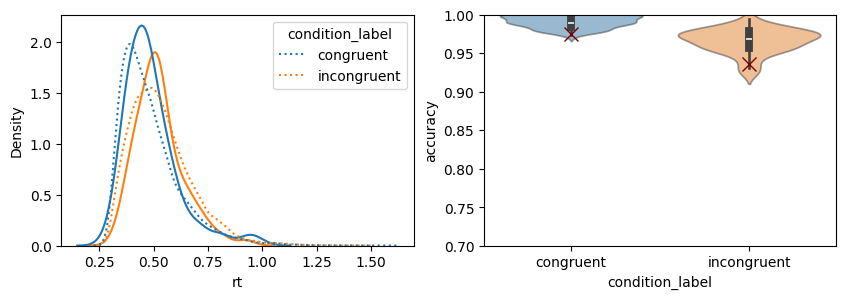

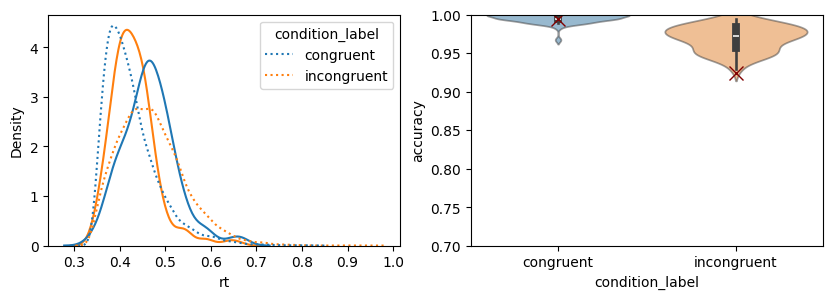

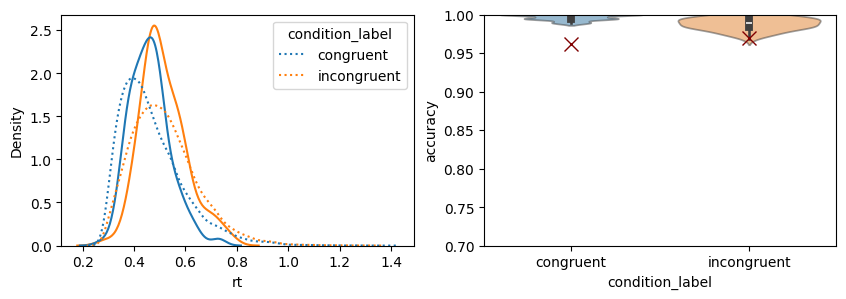

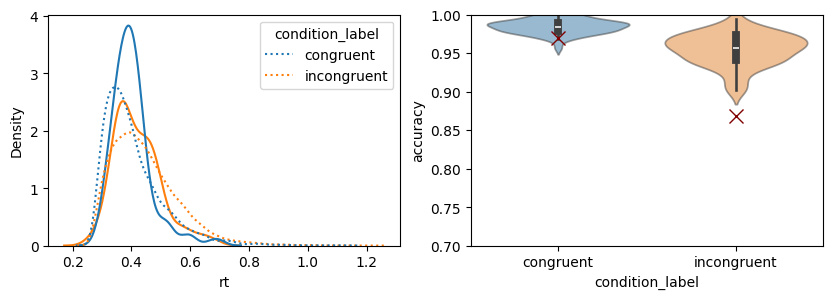

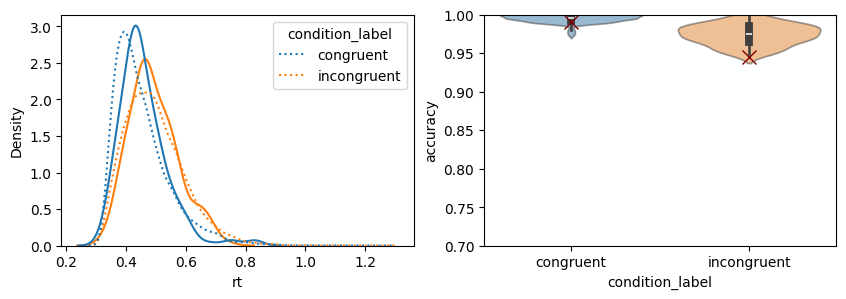

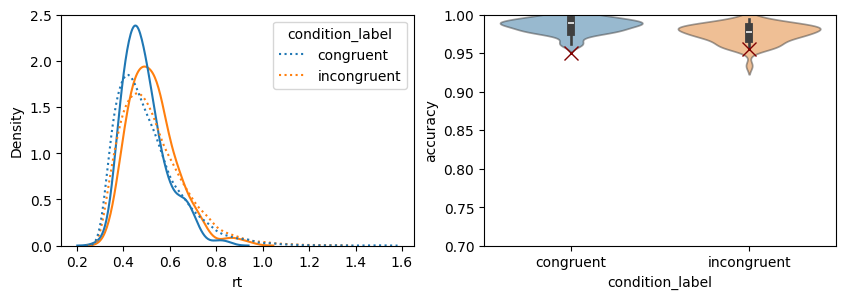

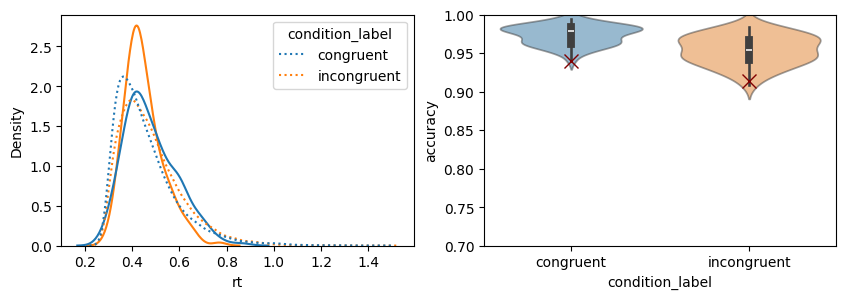

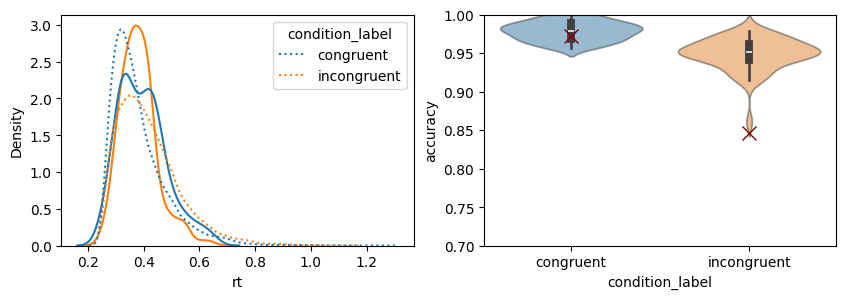

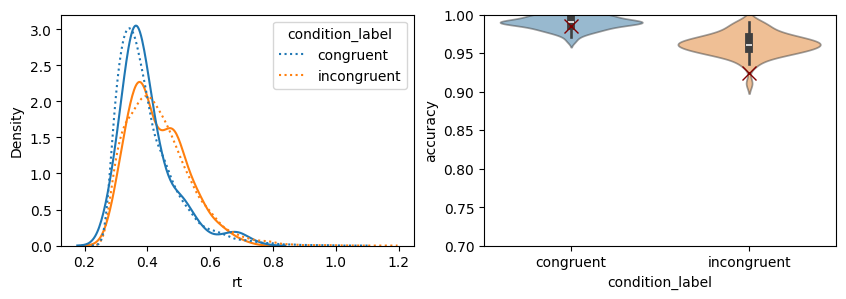

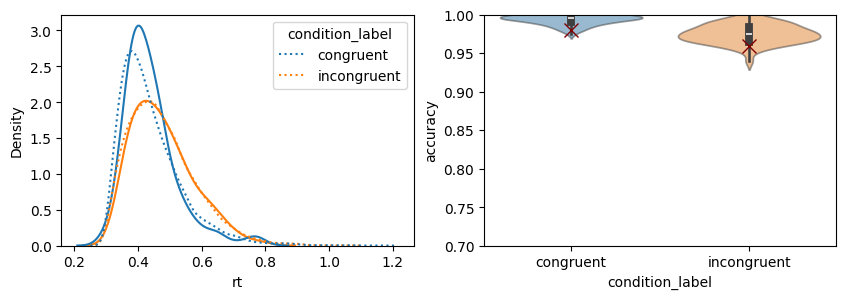

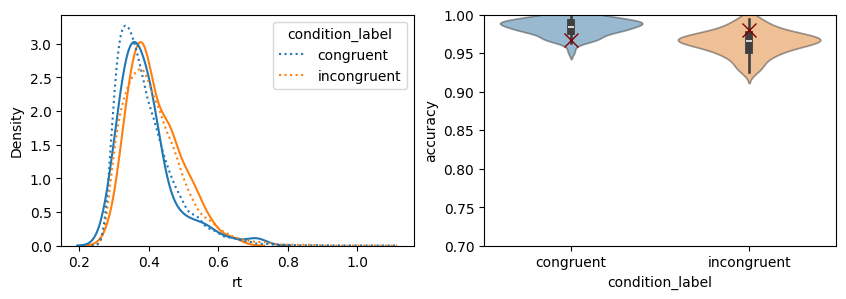

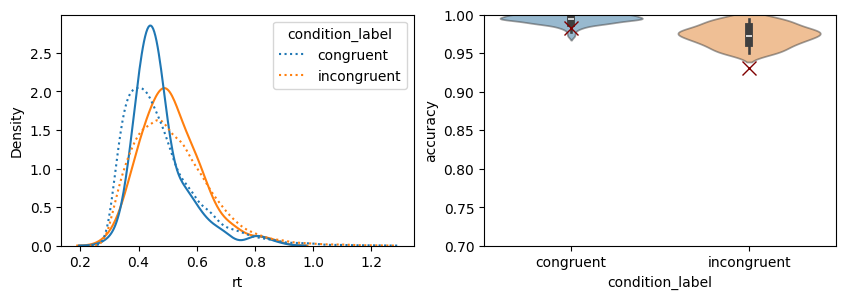

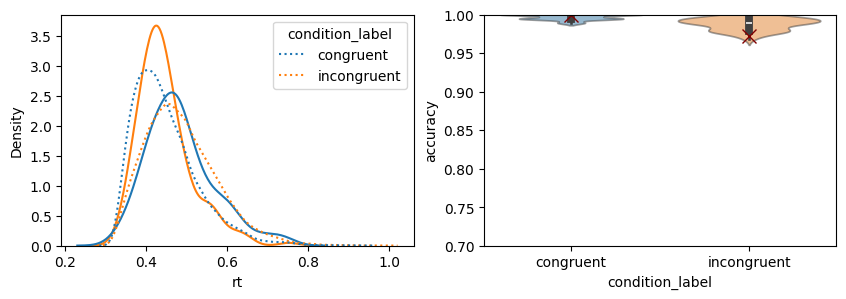

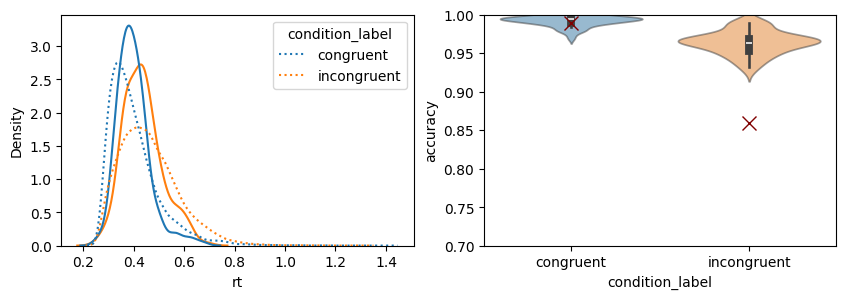

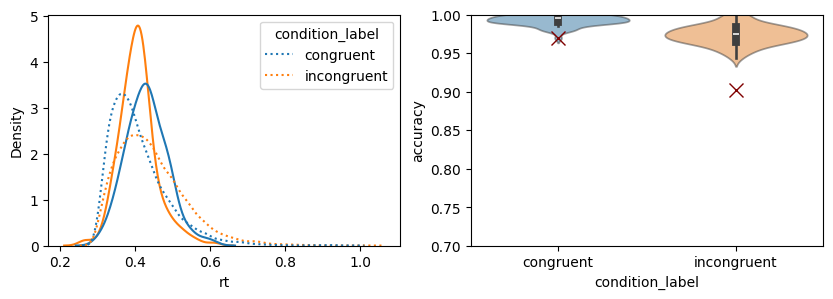

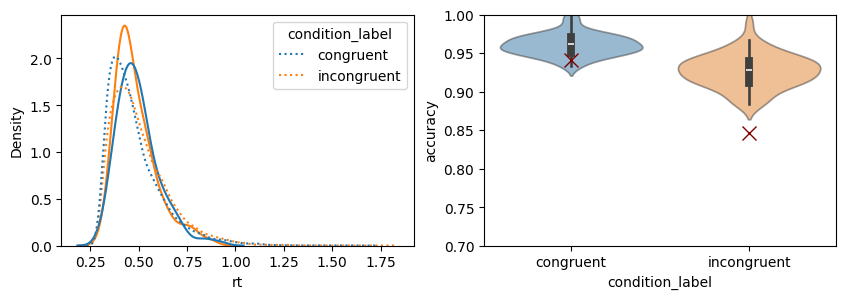

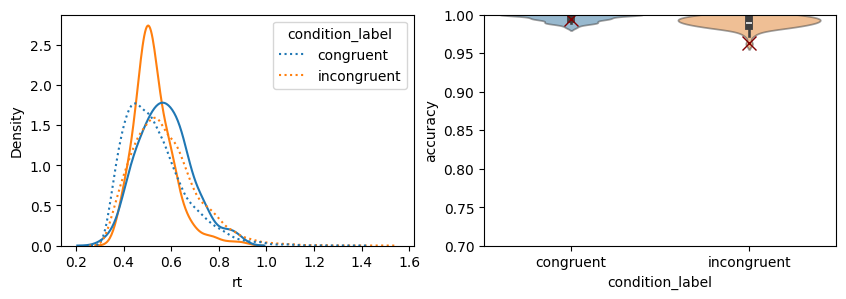

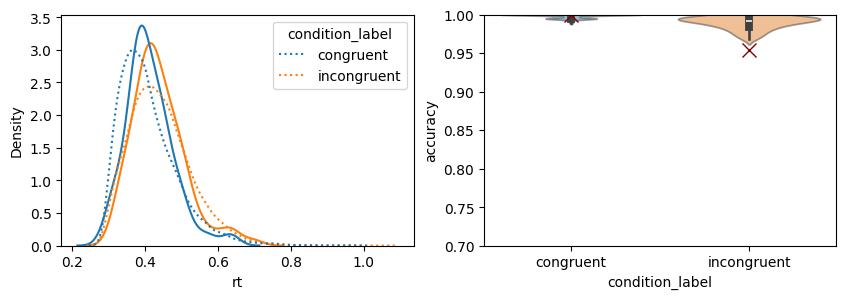

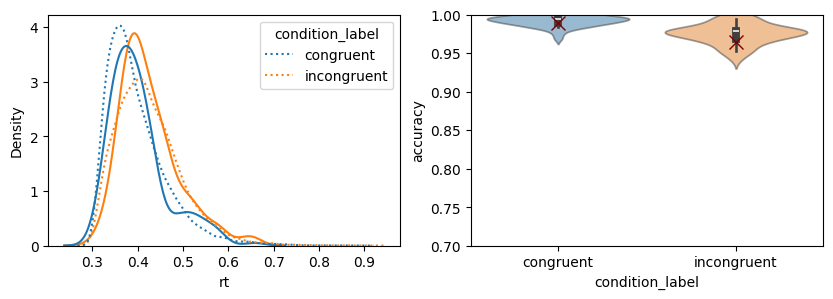

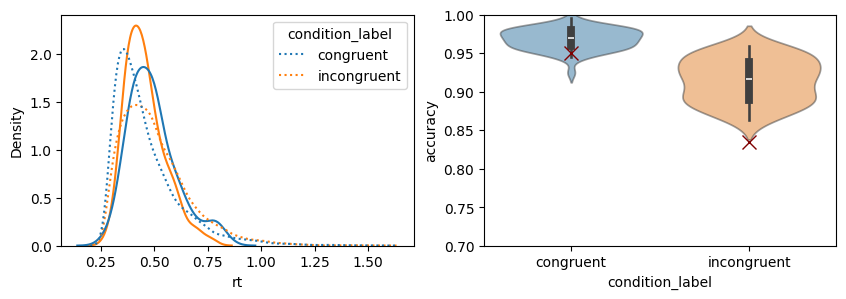

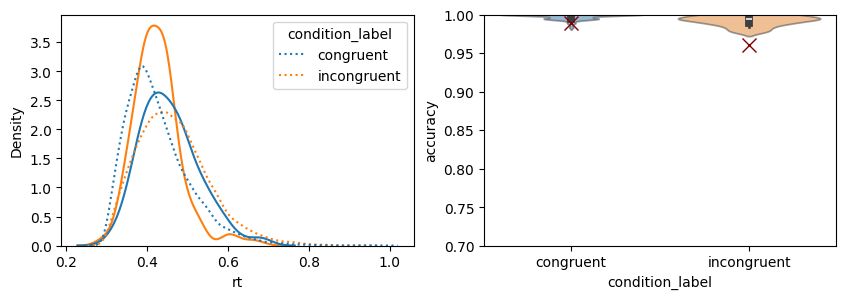

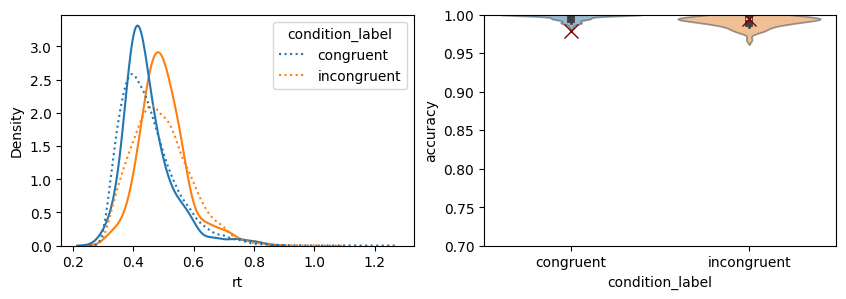

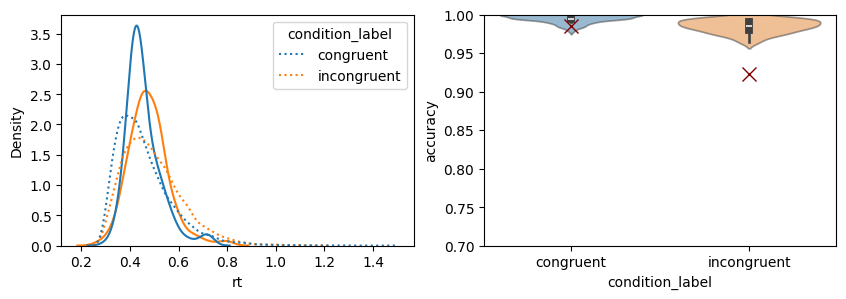

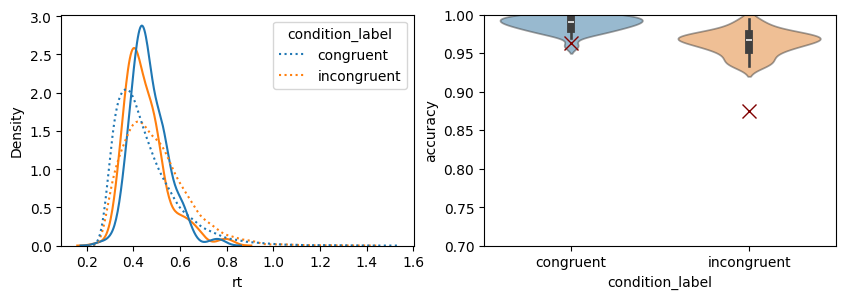

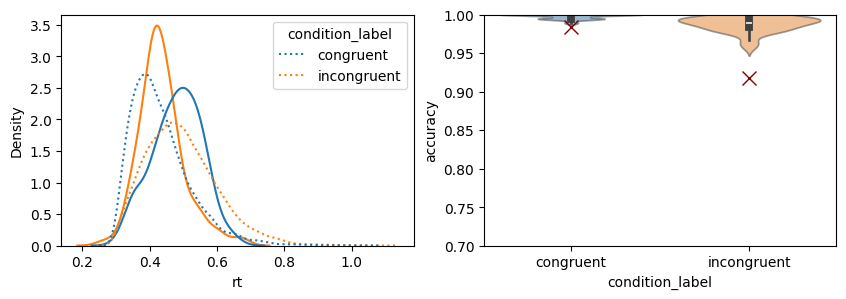

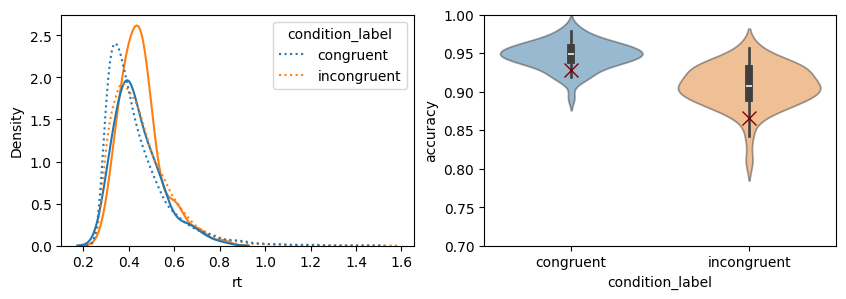

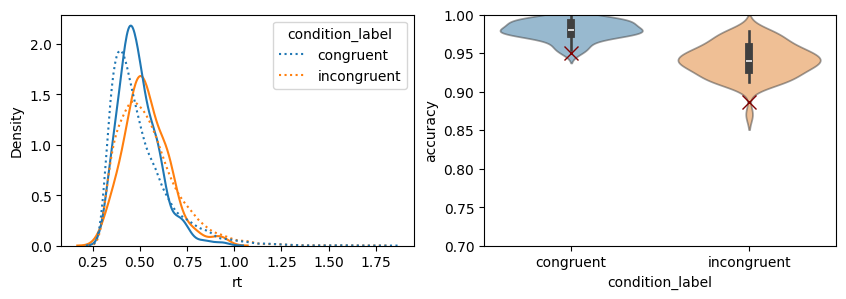

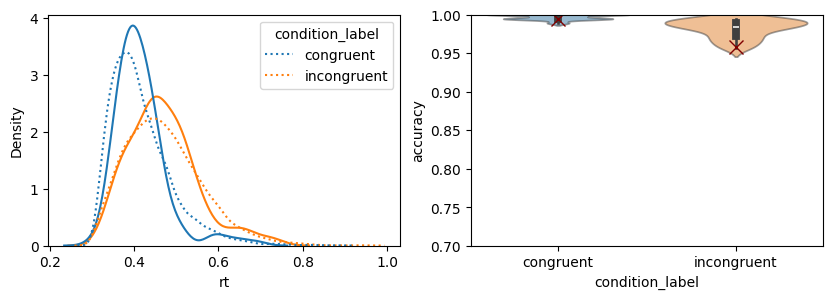

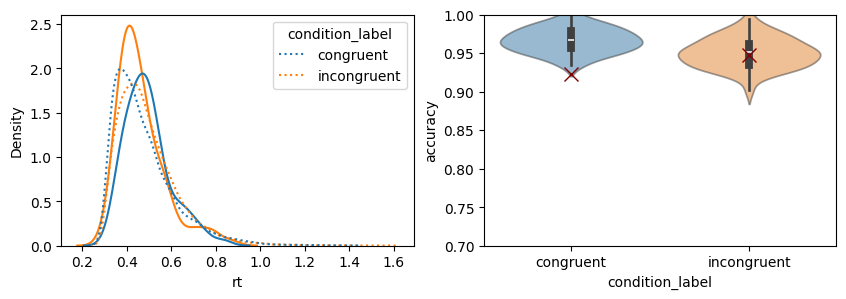

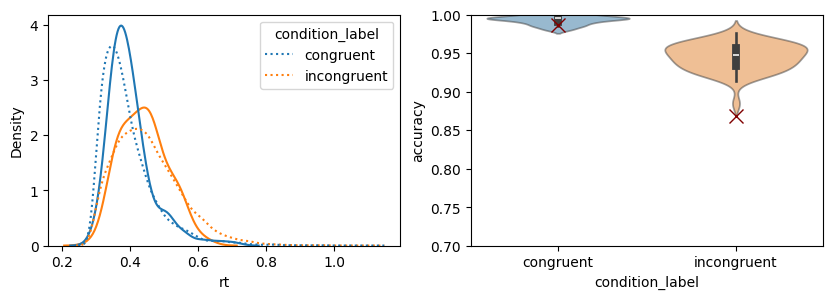

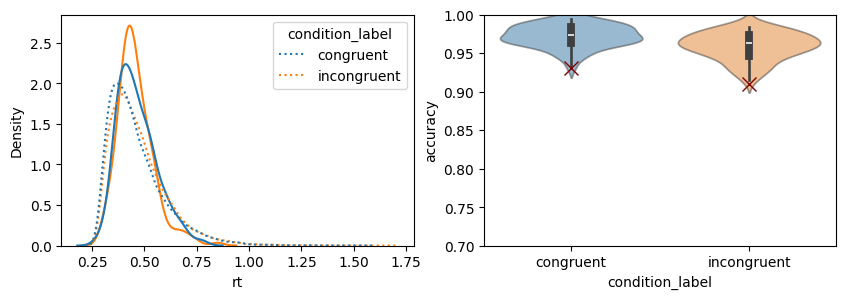

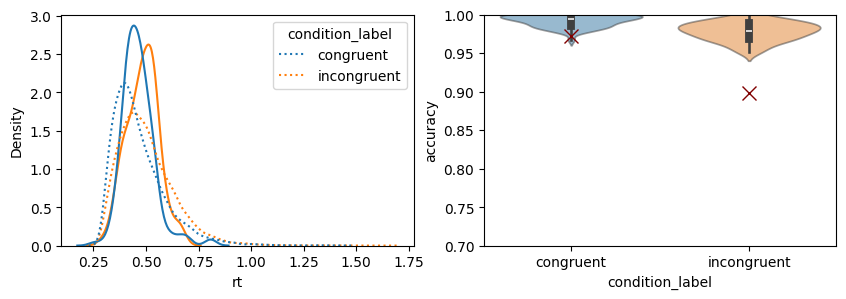

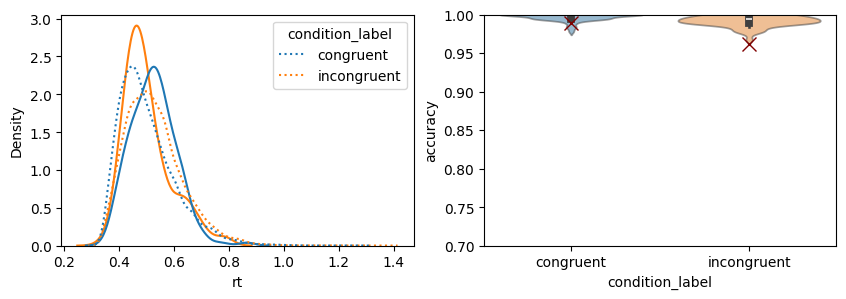

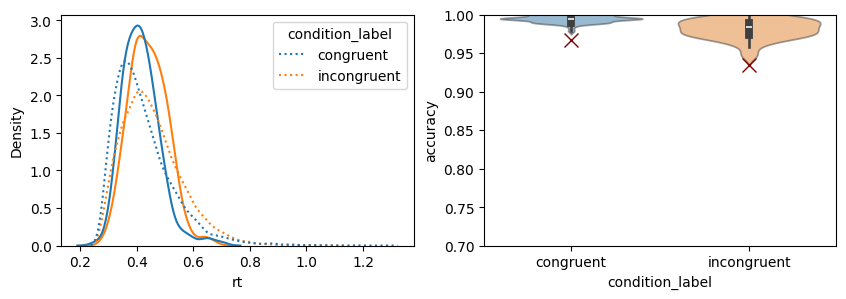

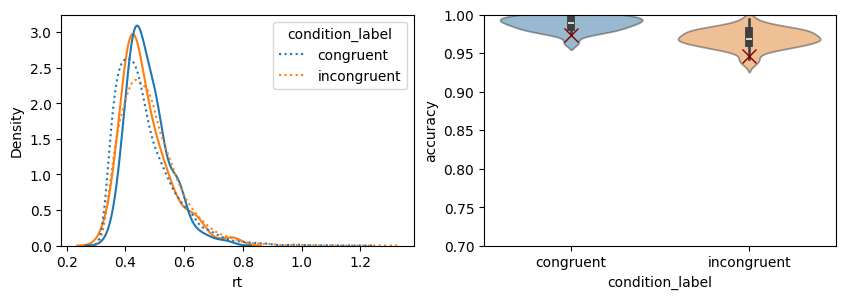

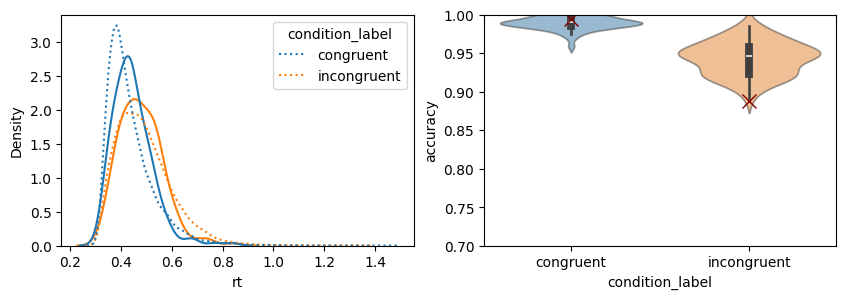

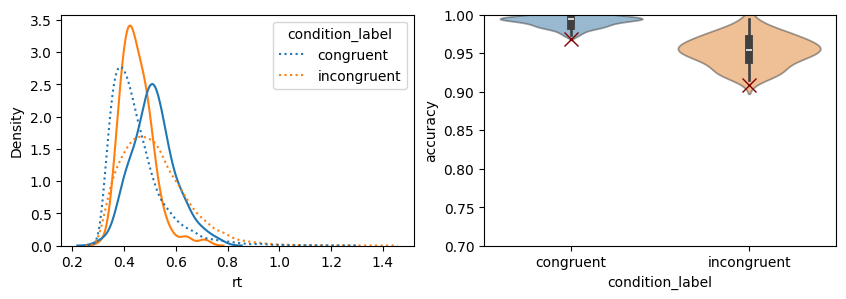

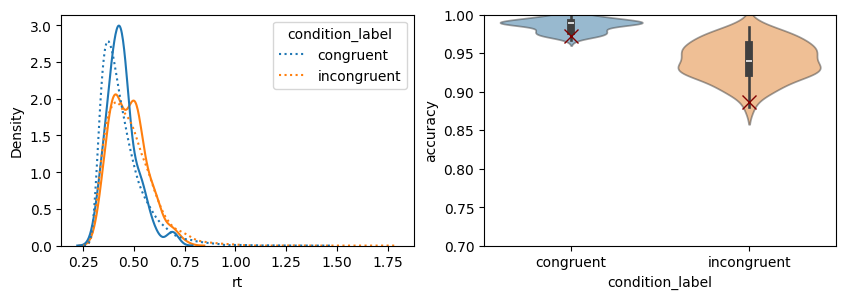

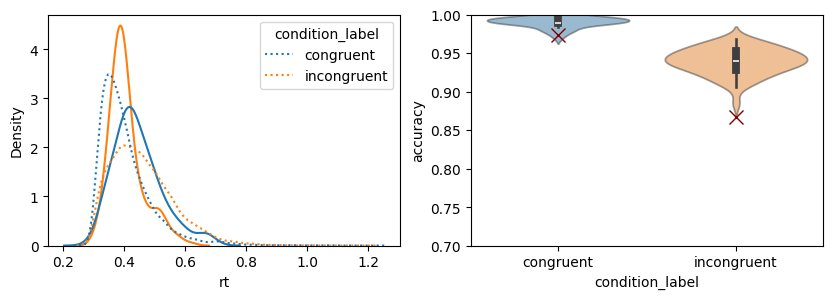

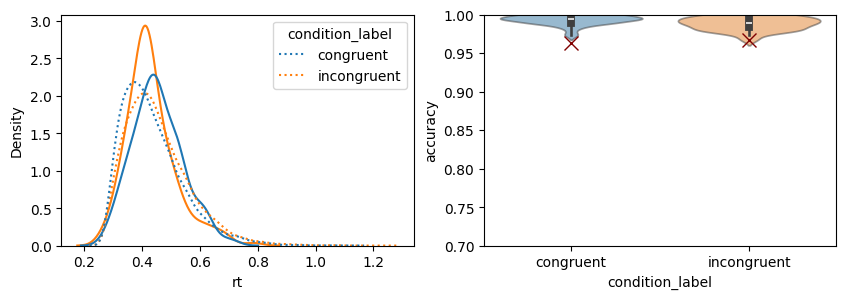

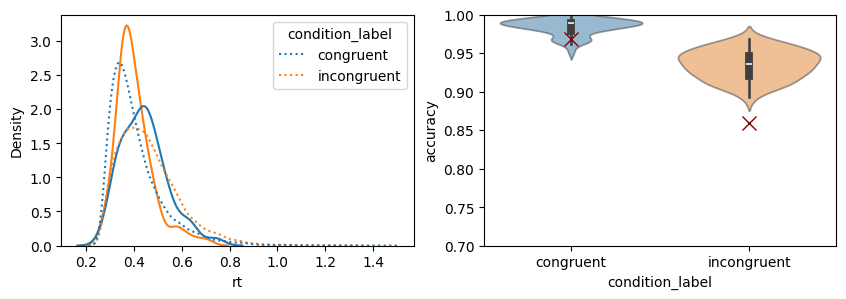

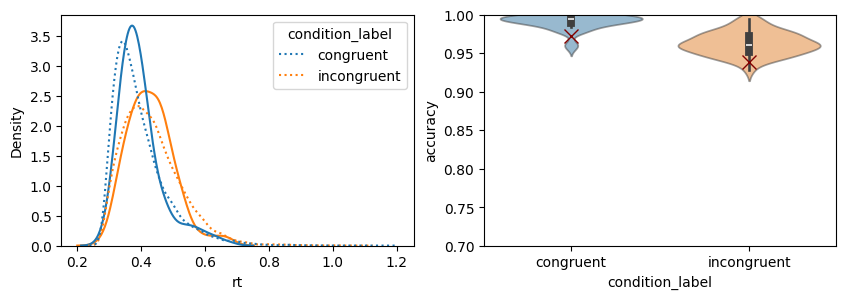

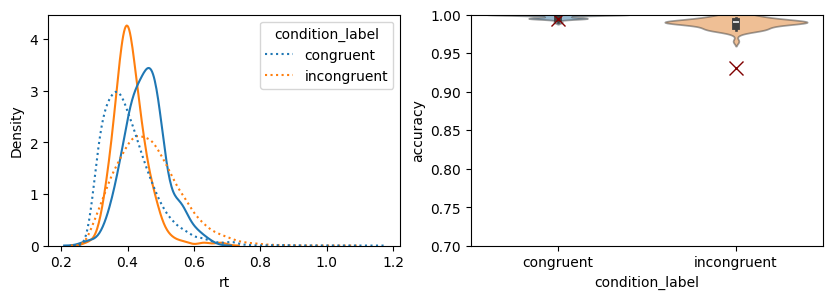

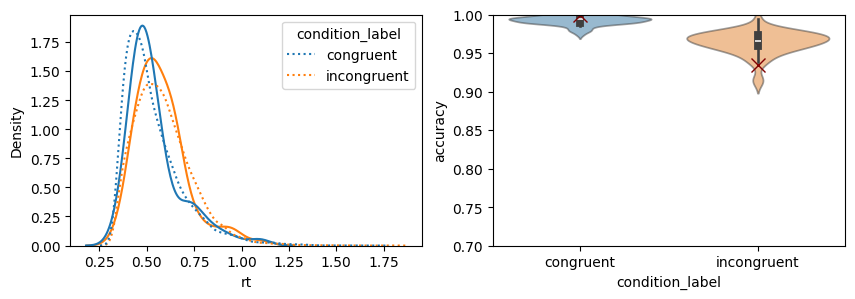

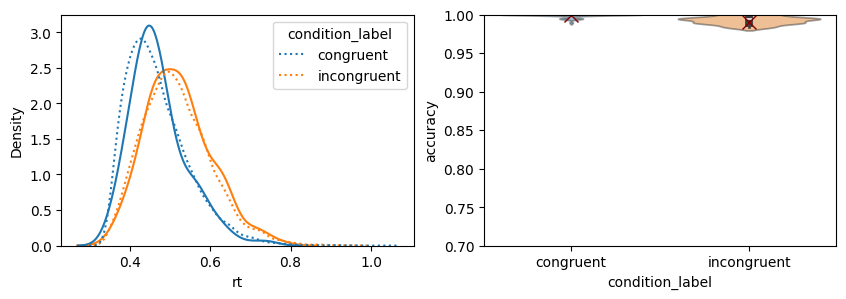

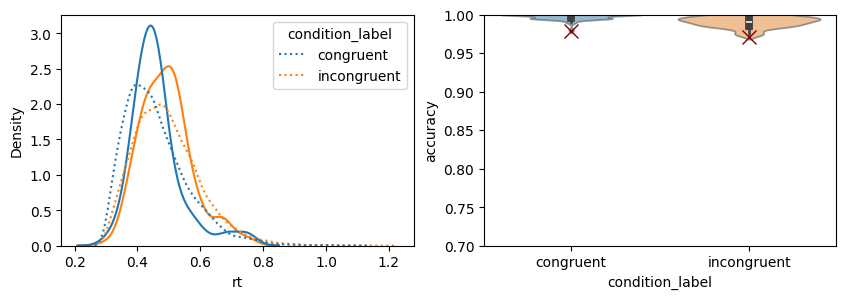

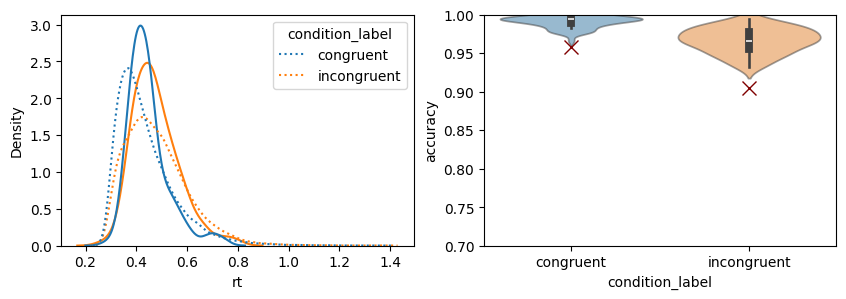

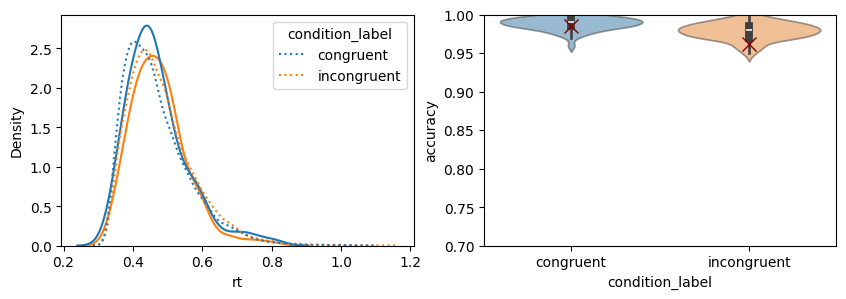

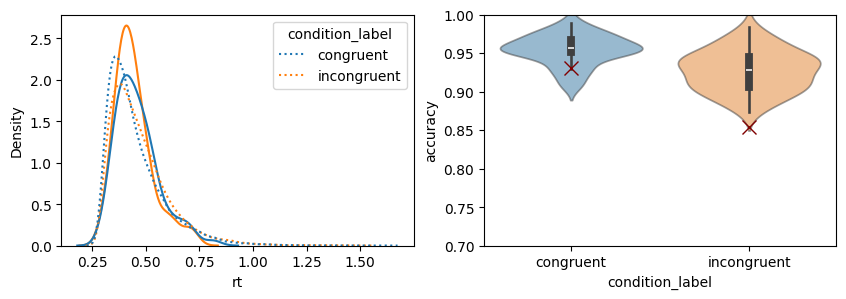

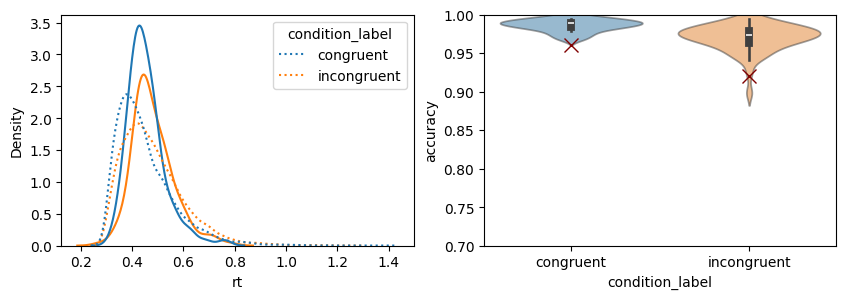

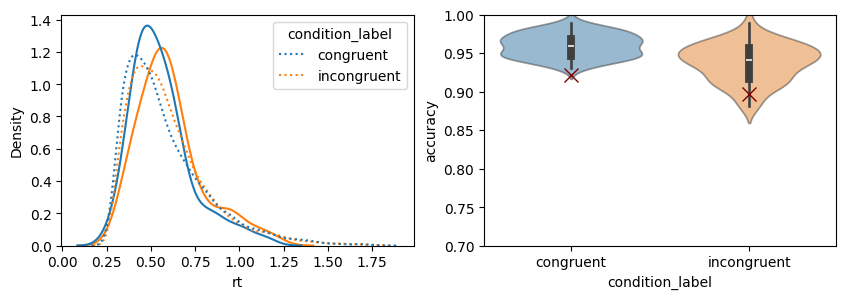

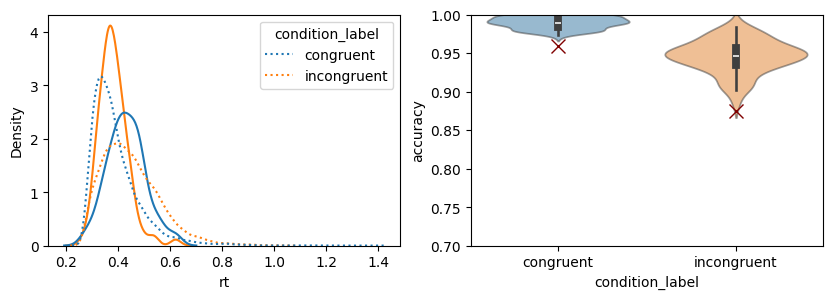

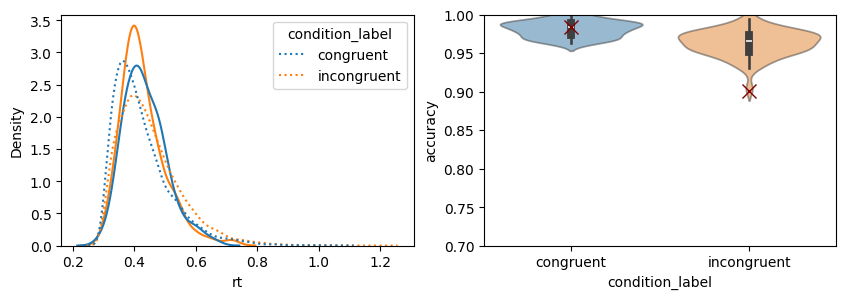

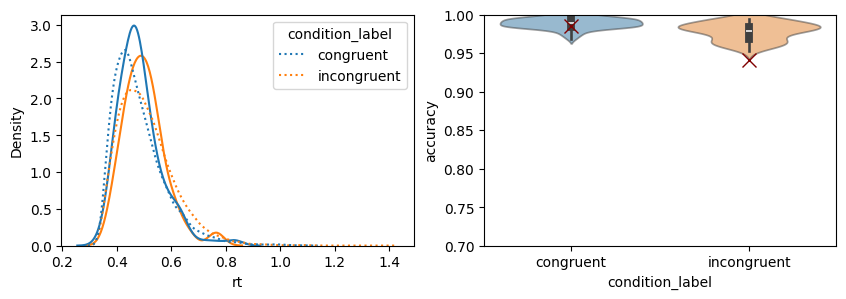

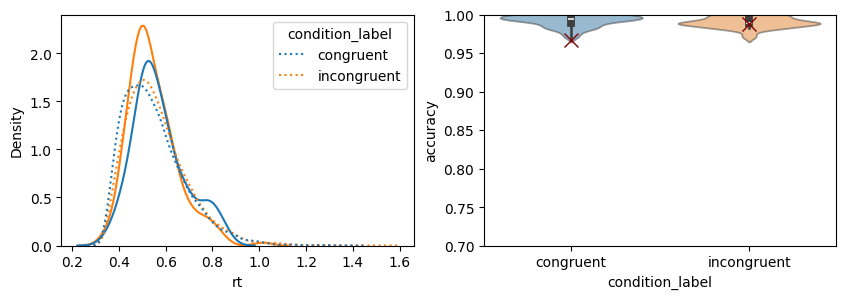

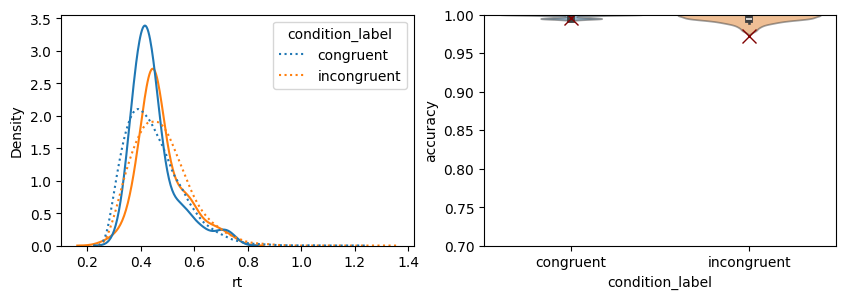

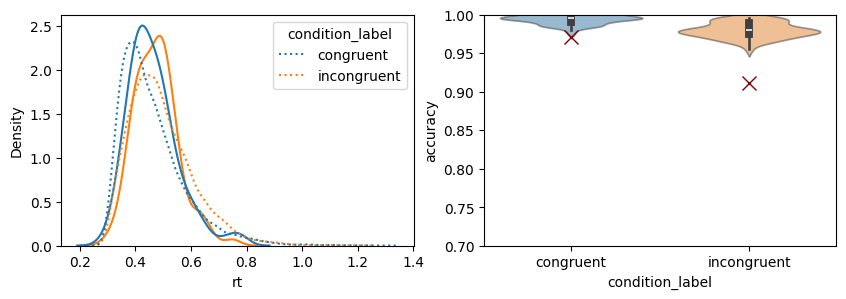

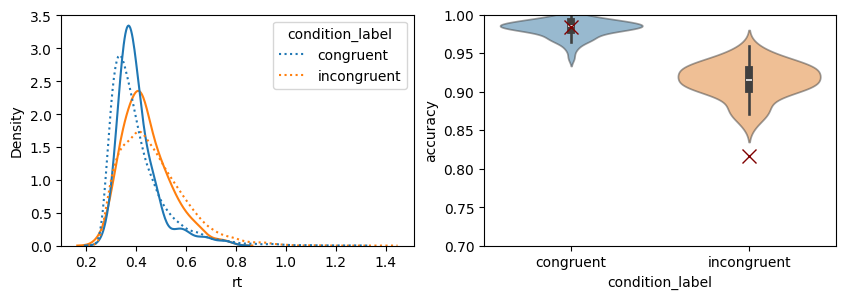

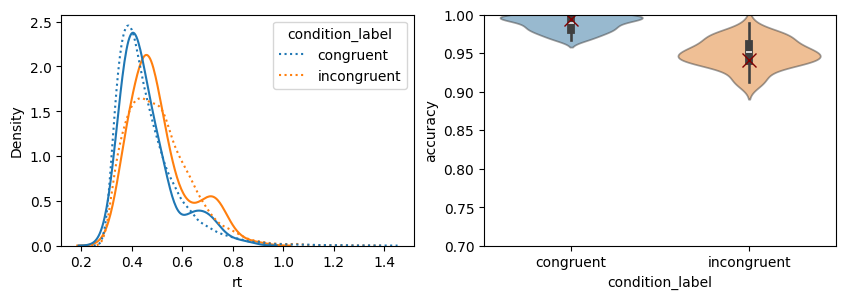

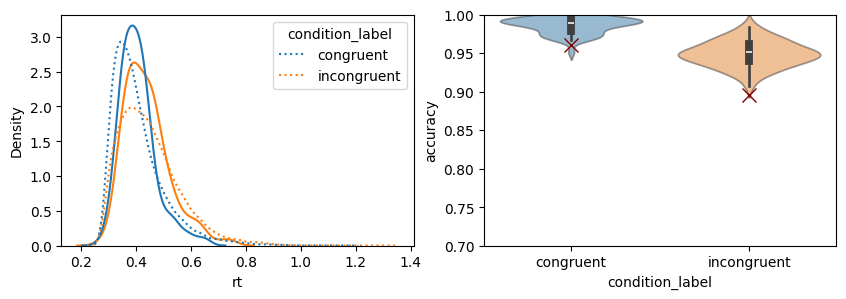

In [16]:

for part in parts:
    
    # filter sample data for given participant and narrow spacing
    part_data_samples = samples_complete[samples_complete["participant"]==part]

    part_data_samples = part_data_samples[part_data_samples["spacing"] == "narrow"]
    
    # filter empirical data for given participant and narrow spacing
    part_data = empirical_data[empirical_data["participant"] == part]

    part_data = part_data[part_data["spacing_num"] == 1]
    
    part_data["condition_label"] = part_data["congruency_num"].map({0.0: "congruent", 1.0: "incongruent"})
    
    # compute empirical accuracy
    empirical_accuracies_congruent.append(np.mean(part_data[part_data["congruency_num"] == 0]["accuracy"]))
    empirical_accuracies_incongruent.append(np.mean(part_data[part_data["congruency_num"] == 1]["accuracy"]))
    
    
    # resimulate data
    data_resimulated = dmc_helpers.resim_data(post_sample_data=part_data_samples, num_obs = part_data.shape[0], simulator=simulator, part=part)

    # resim_data(post_sample_data, num_obs, simulator, part,
    
    # exclude non-convergents
    data_resimulated = data_resimulated[data_resimulated["rt"] != -1]
    
    # recode congruency
    data_resimulated["condition_label"] = data_resimulated["conditions"].map({0.0: "congruent", 1.0: "incongruent"})
    
    # compute resimulated data
    resimulated_accuracies_congruent.append(np.mean(data_resimulated[data_resimulated["conditions"] == 0]["accuracy"]))
    resimulated_accuracies_incongruent.append(np.mean(data_resimulated[data_resimulated["conditions"] == 1]["accuracy"]))
    
    # plot individual fit
    fig, axes = plt.subplots(1,2, figsize=(10,3))

    sns.kdeplot(part_data, x="rt", hue="condition_label", ax=axes[0], label = "Observed")

    sns.kdeplot(data_resimulated, x="rt", hue="condition_label", ax=axes[0], linestyle=":", label = "Predicted")

    aggr_data = part_data.groupby("congruency_num").mean("accuracy")

    # compute mean accuracy empirical data
    aggr_data_resim = data_resimulated.groupby("condition_label").mean("accuracy")
    aggr_data.reset_index(inplace=True)
    
    # recode congruency empirical data
    aggr_data["condition_label"] = aggr_data["congruency_num"].map({0.0: "congruent", 1.0: "incongruent"})
    
    # compute accuracies resimulated data
    aggr_data_resim = data_resimulated.groupby(["num_resim", "conditions"]).mean("accuracy")
    aggr_data_resim.reset_index(inplace=True)
    
    # recode congruency resimulated data
    aggr_data_resim["condition_label"] = aggr_data_resim["conditions"].map({0.0: "congruent", 1.0: "incongruent"})

    sns.violinplot(aggr_data_resim, x="condition_label", 
                y="accuracy", hue="condition_label", ax=axes[1], label = "Resimulated", alpha=0.5)
    axes[1].plot(aggr_data["condition_label"], aggr_data["accuracy"], "x", color="maroon", markersize=10)
    plt.ylim(0.7, 1)


<Axes: ylabel='Count'>

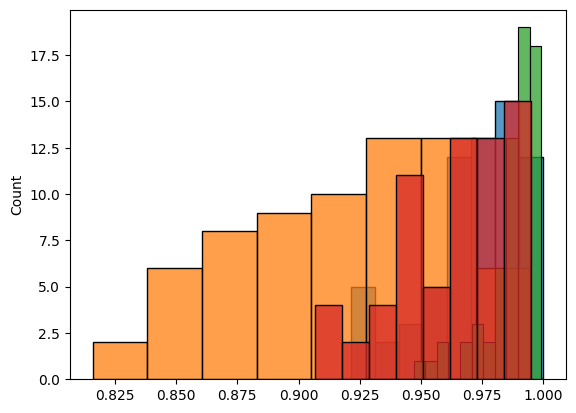

In [17]:
sns.histplot(empirical_accuracies_congruent, label="Empirical Congruent")
sns.histplot(empirical_accuracies_incongruent, label="Empirical Incongruent")
sns.histplot(resimulated_accuracies_congruent, label="Resimulated Congruent")
sns.histplot(resimulated_accuracies_incongruent, label="Resimulated Incongruent")

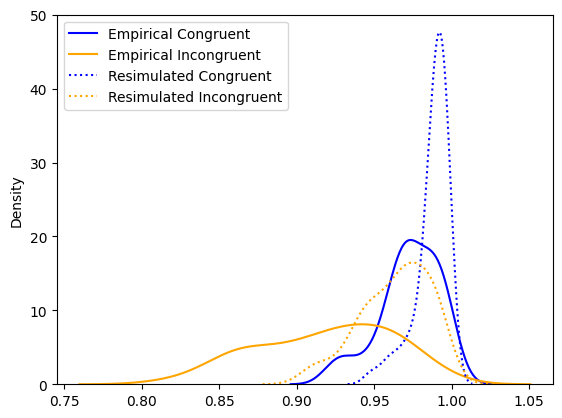

In [18]:
sns.kdeplot(empirical_accuracies_congruent, label="Empirical Congruent", color="blue")
sns.kdeplot(empirical_accuracies_incongruent, label="Empirical Incongruent", color="orange")
sns.kdeplot(resimulated_accuracies_congruent, linestyle=":", label="Resimulated Congruent", color="blue")
sns.kdeplot(resimulated_accuracies_incongruent, linestyle=":", label="Resimulated Incongruent", color="orange")
plt.legend()

In [19]:
data_resimulated

rt  accuracy  conditions  num_obs  num_resim  participant  \
0    0.386624       1.0           0      369          0          985   
1    0.301624       1.0           0      369          0          985   
2    0.328624       1.0           0      369          0          985   
3    0.340624       1.0           0      369          0          985   
4    0.435624       1.0           0      369          0          985   
..        ...       ...         ...      ...        ...          ...   
364  0.491571       1.0           1      369         49          985   
365  0.565571       1.0           1      369         49          985   
366  0.487571       1.0           1      369         49          985   
367  0.521571       1.0           1      369         49          985   
368  0.359571       0.0           1      369         49          985   

    condition_label  
0         congruent  
1         congruent  
2         congruent  
3         congruent  
4         congruent  
..              ...  
364     incongruent  
365     incongruent  
366     incongruent  
367     incongruent  
368     incongruent  

[18450 rows x 7 columns]

## Delta Functions

In [20]:
def delta_functions(data, quantiles = np.arange(0,1, 0.1), 
                  grouping_labels=["participant", "condition_label"],
                  rt_var="rt",
                  congruency_name="condition_label"):
    

    quantile_data = data.groupby(grouping_labels)[rt_var].quantile(quantiles).reset_index()
    
    quantile_data.rename(columns={"level_2": "quantiles"}, inplace=True)

    quantile_data_wide = quantile_data.pivot(index="quantiles", columns=congruency_name, values=rt_var)

    quantile_data_wide["delta"] = quantile_data_wide["incongruent"] - quantile_data_wide["congruent"]

    quantile_data_wide["mean_qu"] = (quantile_data_wide["incongruent"] + quantile_data_wide["congruent"])/2

    return quantile_data_wide


empirical_data

data_resimulated

rt  accuracy  conditions  num_obs  num_resim  participant  \
0    0.386624       1.0           0      369          0          985   
1    0.301624       1.0           0      369          0          985   
2    0.328624       1.0           0      369          0          985   
3    0.340624       1.0           0      369          0          985   
4    0.435624       1.0           0      369          0          985   
..        ...       ...         ...      ...        ...          ...   
364  0.491571       1.0           1      369         49          985   
365  0.565571       1.0           1      369         49          985   
366  0.487571       1.0           1      369         49          985   
367  0.521571       1.0           1      369         49          985   
368  0.359571       0.0           1      369         49          985   

    condition_label  
0         congruent  
1         congruent  
2         congruent  
3         congruent  
4         congruent  
..              ...  
364     incongruent  
365     incongruent  
366     incongruent  
367     incongruent  
368     incongruent  

[18450 rows x 7 columns]

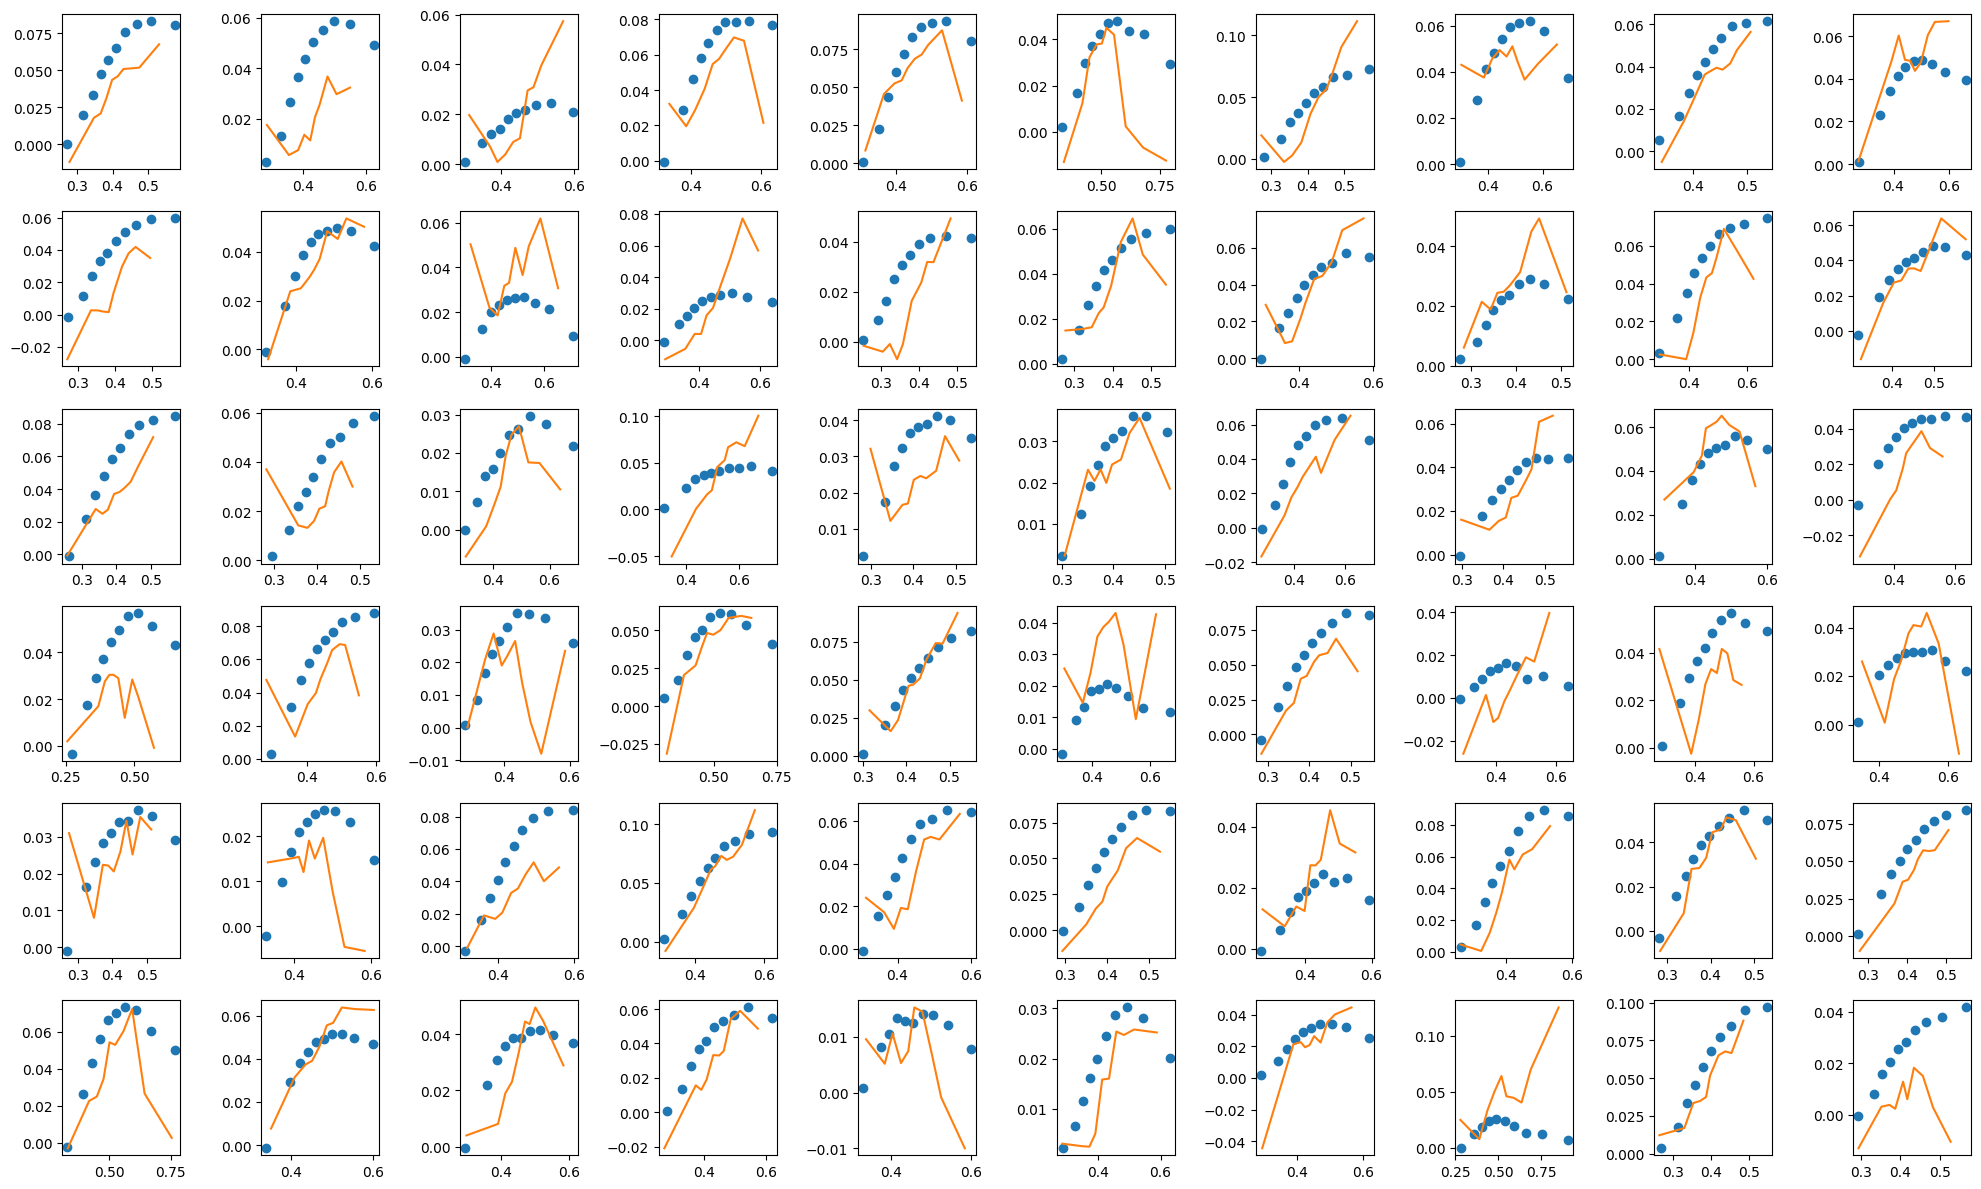

In [21]:
fig, axes = plt.subplots(6, 10, figsize=(20,12))

axes = axes.flatten()

for part, ax in zip(parts, axes):
    
    # filter sample data for given participant and narrow spacing
    part_data_samples = samples_complete[samples_complete["participant"]==part]

    part_data_samples = part_data_samples[part_data_samples["spacing"] == "narrow"]

    # filter empirical data for given participant and narrow spacing
    part_data = empirical_data[empirical_data["participant"] == part]

    part_data = part_data[part_data["spacing_num"] == 1]

    part_data["condition_label"] = part_data["congruency_num"].map({0.0: "congruent", 1.0: "incongruent"})

    # resimulate data
    data_resimulated = dmc_helpers.resim_data(post_sample_data=part_data_samples, num_obs = part_data.shape[0], simulator=simulator, part=part)


    # exclude non-convergents
    data_resimulated = data_resimulated[data_resimulated["rt"] != -1]

    # recode congruency
    data_resimulated["condition_label"] = data_resimulated["conditions"].map({0.0: "congruent", 1.0: "incongruent"})

    quantiles = np.arange(0,1, 0.1)

    quantile_data_wide_resim = delta_functions(data_resimulated, quantiles = np.arange(0, 1, 0.1))

    quantile_data_wide_empirical = delta_functions(part_data, quantiles = np.arange(0, 1, 0.1))

    ax.plot(quantile_data_wide_resim["mean_qu"] ,quantile_data_wide_resim["delta"] ,"o")
    ax.plot(quantile_data_wide_empirical["mean_qu"] ,quantile_data_wide_empirical["delta"] )

fig.tight_layout()
    

## Reliability 

In [22]:
narrow_data_even=narrow_data.iloc[::2]

narrow_data_odd=narrow_data.iloc[1::2]

post_samples_narrow_even = dmc_helpers.fit_empirical_data(narrow_data_even, approximator)

post_samples_narrow_odd = dmc_helpers.fit_empirical_data(narrow_data_odd, approximator)

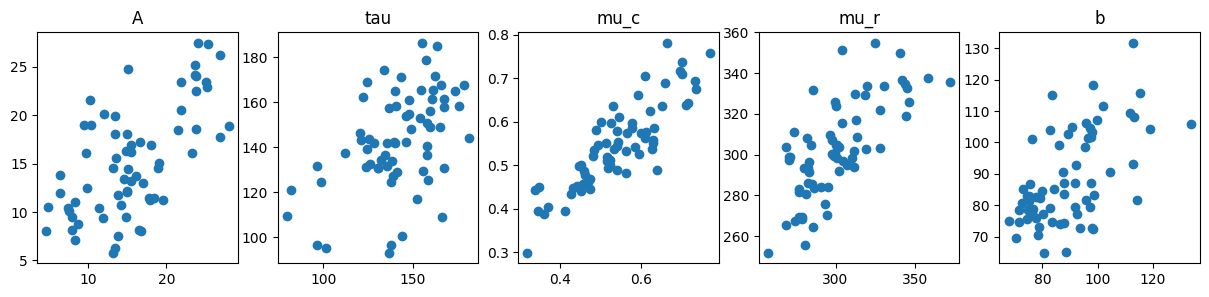

In [24]:
post_median_odd = post_samples_narrow_odd.groupby("participant").median()

post_median_even = post_samples_narrow_even.groupby("participant").median()

fig, axes = plt.subplots(1,5, figsize=(15,3))
for p, ax in zip(model_specs['param_names'], axes):
    ax.plot(post_median_odd[p], post_median_even[p], "o")
    ax.plot([])
    
    ax.set_title(p)

## Trial dependency

In [25]:
model_specs

{'simulation_settings': {'prior_means': array([ 16. , 111. ,   0.5, 322. ,  75. ]),
  'prior_sds': array([10.  , 47.  ,  0.13, 40.  , 23.  ]),
  'tmax': 1500,
  'contamination_probability': None,
  'min_num_obs': 50,
  'max_num_obs': 800,
  'fixed_num_obs': None},
 'inference_network_settings': {'coupling_kwargs': {'subnet_kwargs': {'dropout': 0.0100967297}},
  'depth': 10},
 'summary_network_settings': {'dropout': 0.0100967297,
  'num_seeds': 2,
  'summary_dim': 32,
  'embed_dim': (128, 128)},
 'batch_size': 16,
 'learning_rate': 0.0004916,
 'param_names': ['A', 'tau', 'mu_c', 'mu_r', 'b']}

In [38]:
simulator = DMC(**model_specs['simulation_settings'])

adapter = (
    bf.adapters.Adapter()
    .convert_dtype("float64", "float32")
    .sqrt("num_obs")
    .concatenate(model_specs['param_names'], into="inference_variables")
    .concatenate(["rt", "accuracy", "conditions"], into="summary_variables")
    .standardize(include="inference_variables")
    .rename("num_obs", "inference_conditions")
)
# Create inference net 
inference_net = bf.networks.CouplingFlow(**model_specs['inference_network_settings'])

# inference_net = bf.networks.FlowMatching(subnet_kwargs=dict(dropout=0.1))

summary_net = bf.networks.SetTransformer(**model_specs['summary_network_settings'])

workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    initial_learning_rate=model_specs['learning_rate'],
    inference_network=inference_net,
    summary_network=summary_net,
    checkpoint_filepath='../data/training_checkpoints',
    checkpoint_name= network_name,
    inference_variables=model_specs['param_names']
)

approximator = keras.saving.load_model(network_dir)

workflow.approximator = approximator

Existing checkpoints can _not_ be restored/loaded using this workflow. Upon refitting, the checkpoints will be overwritten. To load the stored approximator from the checkpoint, use approximator = keras.saving.load_model(...)
/home/administrator/miniforge3/envs/bf_new/lib/python3.11/site-packages/keras/src/saving/serialization_lib.py:734: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)


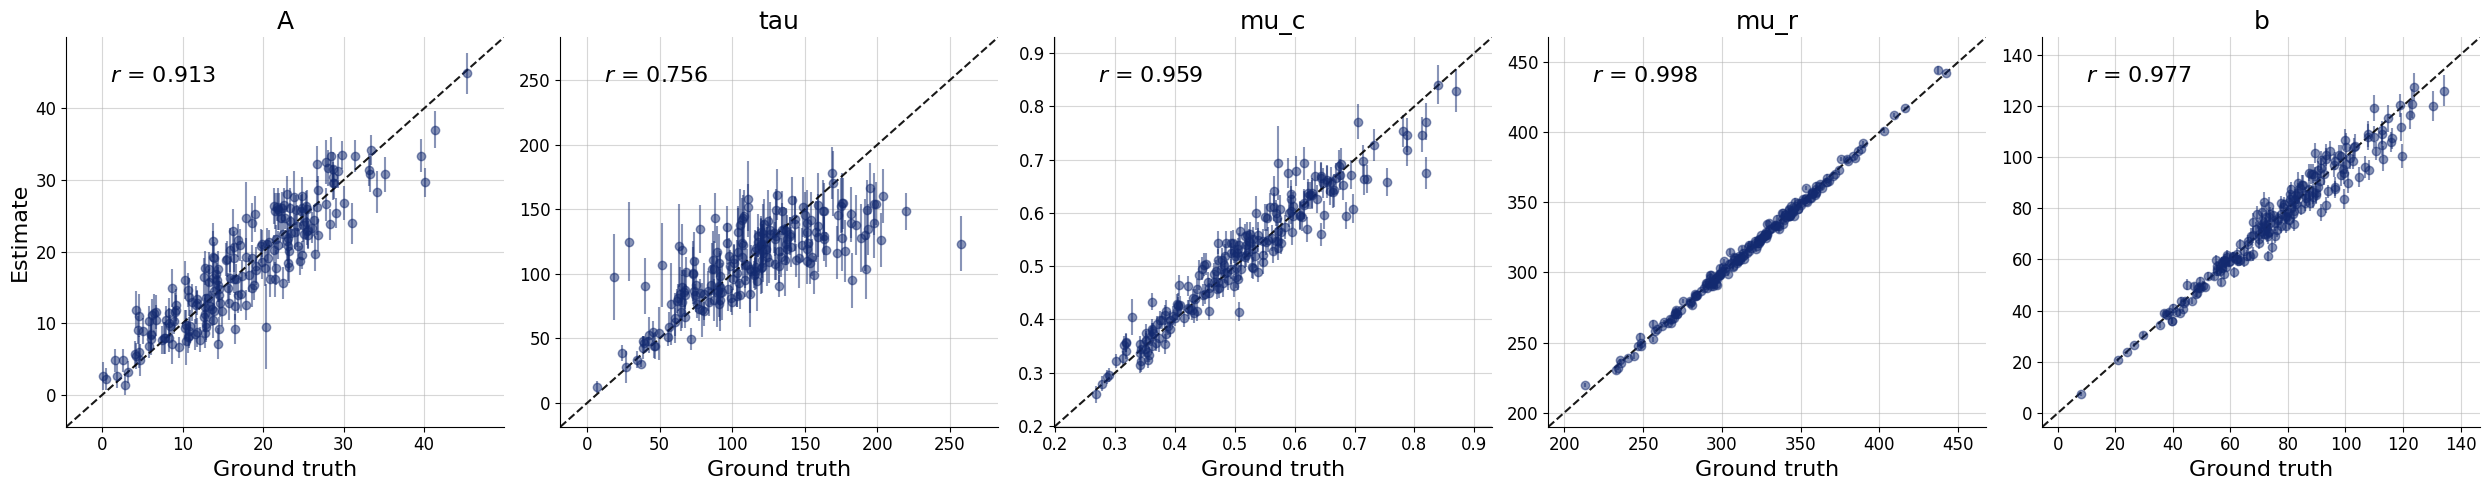

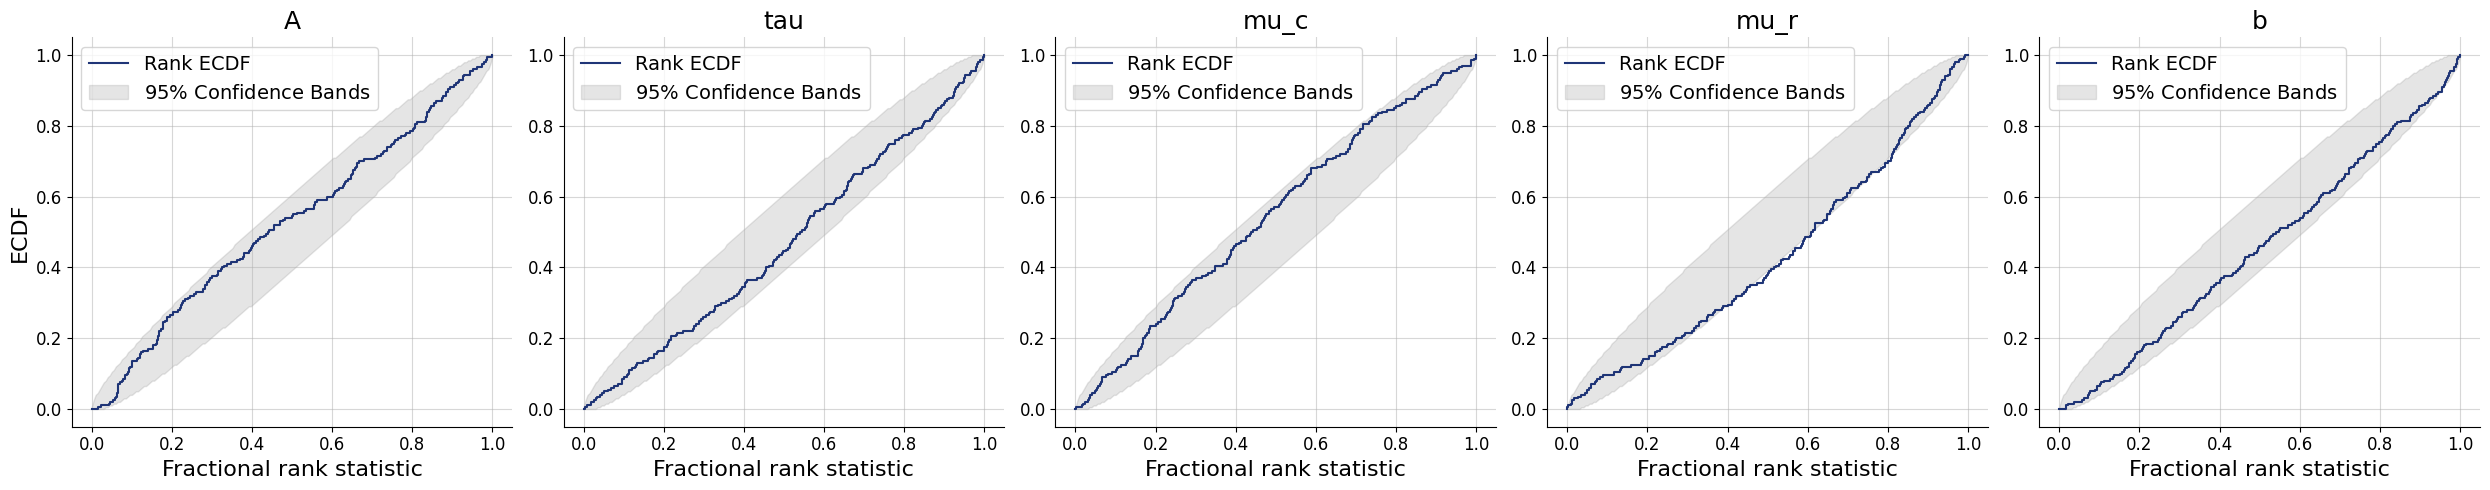

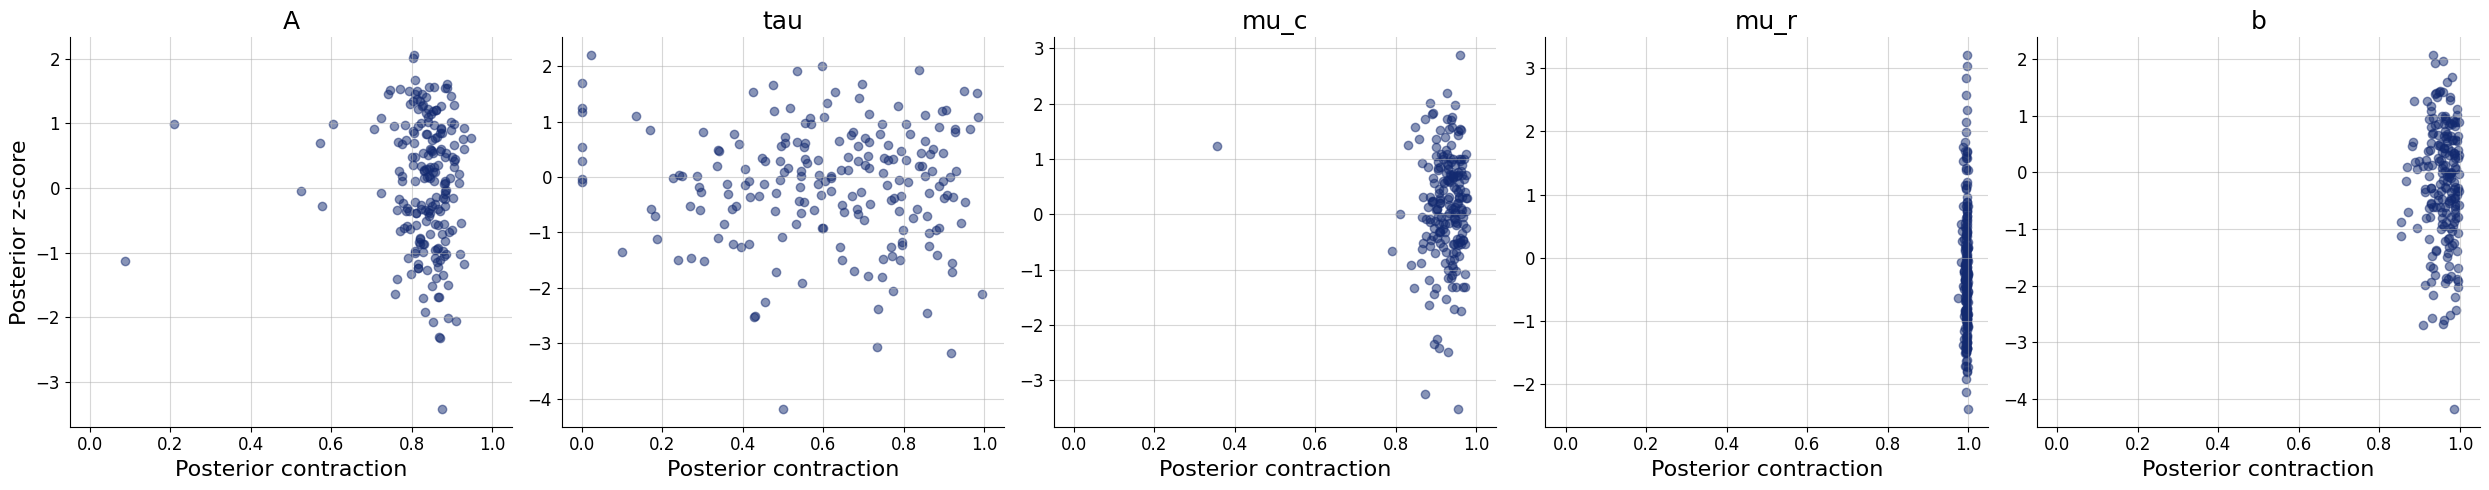

In [45]:

simulator.fixed_num_obs = 300

val_data = simulator.sample(200)

_ = workflow.sample(conditions=val_data, num_samples=100)

figs = workflow.plot_default_diagnostics(test_data=val_data)

In [47]:
file_path = '../data/data_offline_training/data_offline_training.pickle'

# train_data = simulator.sample(50000)

# with open(file_path, 'wb') as file:
#     pickle.dump(train_data, file)

with open(file_path, 'rb') as file:
    train_data = pickle.load(file)
    
        
val_file_path = '../data/data_offline_training/data_offline_validation.pickle'

with open(val_file_path, 'rb') as file:
    val_data = pickle.load(file)
    
train_data.keys()

dict_keys(['A', 'tau', 'mu_c', 't0', 'b', 'rt', 'accuracy', 'conditions', 'num_obs'])

In [ ]:
train_data["mu_r"] = train_data.pop("t0")

val_data["mu_r"] = val_data.pop("t0")

# val_data.keys()

In [23]:
%%time
history = workflow.fit_offline(train_data, epochs=1, batch_size=32, validation_data=val_data)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 258s 165ms/step - loss: 2.7021 - loss/inference_loss: 2.7021 - val_loss: 2.4188 - val_loss/inference_loss: 2.4188


INFO:bayesflow:Training is now finished.
            You can find the trained approximator at '../checkpoints/simons_crazy_net_test_metrics.simons_crazy_net_test_metrics.keras'.
            To load it, use approximator = keras.saving.load_model(...).


CPU times: user 4min 15s, sys: 2.5 s, total: 4min 18s
Wall time: 4min 17s


In [122]:
approximator = keras.saving.load_model("../checkpoints/simons_crazy_net_test_metrics.keras")

data = simulator.sample(10)

samples = approximator.sample(conditions=data, num_samples=1000)

bf.diagnostics.metrics.calibration_error(samples, data)

{'values': VariableArray([0.03447368, 0.07184211, 0.07605263, 0.42394737, 0.37394737]),
 'metric_name': 'Calibration Error',
 'variable_names': ['A', 'tau', 'mu_c', 'mu_r', 'b']}

In [120]:
import pandas as pd

list_metrics = []

num_max_obs = 500

for n_obs in range(5, num_max_obs, 20):
    
    simulator.num_obs = n_obs
    
    val_data = simulator.sample(200)
    
    metrics_table=workflow.compute_default_diagnostics(test_data=val_data)
    
    metrics_table["num_obs"] = n_obs
    
    list_metrics.append(metrics_table)
    
data_set_metrics = pd.concat(list_metrics)

data_set_metrics

A       tau      mu_c      mu_r         b  \
NRMSE                  0.287864  0.326023  0.279874  0.185241  0.252931   
Posterior Contraction  0.224140  0.029860  0.535445  0.826286  0.402872   
Calibration Error      0.049211  0.043026  0.290395  0.225395  0.194868   
NRMSE                  0.256757  0.359789  0.192594  0.103762  0.168395   
Posterior Contraction  0.109561  0.000000  0.760513  0.889855  0.722741   
...                         ...       ...       ...       ...       ...   
Posterior Contraction  0.492626  0.027810  0.918668  0.985951  0.962461   
Calibration Error      0.011447  0.013158  0.207368  0.410395  0.282895   
NRMSE                  0.208512  0.267188  0.098560  0.067064  0.091801   
Posterior Contraction  0.535093  0.025321  0.928028  0.987486  0.968217   
Calibration Error      0.013947  0.012368  0.194868  0.371974  0.322895   

                       num_obs  
NRMSE                        5  
Posterior Contraction        5  
Calibration Error            5  
NRMSE                       25  
Posterior Contraction       25  
...                        ...  
Posterior Contraction      465  
Calibration Error          465  
NRMSE                      485  
Posterior Contraction      485  
Calibration Error          485  

[75 rows x 6 columns]

In [117]:
data_set_metrics.reset_index(inplace=True, names="metric")
data_set_metrics


ValueError: cannot insert metric, already exists

In [118]:
data_metrics_long =data_set_metrics.melt(id_vars=["metric", "num_obs"], value_vars=["A", "tau", "mu_c", "mu_r", "b"], var_name="parameter", value_name="score")

AttributeError: 'Axes' object has no attribute 'set_'

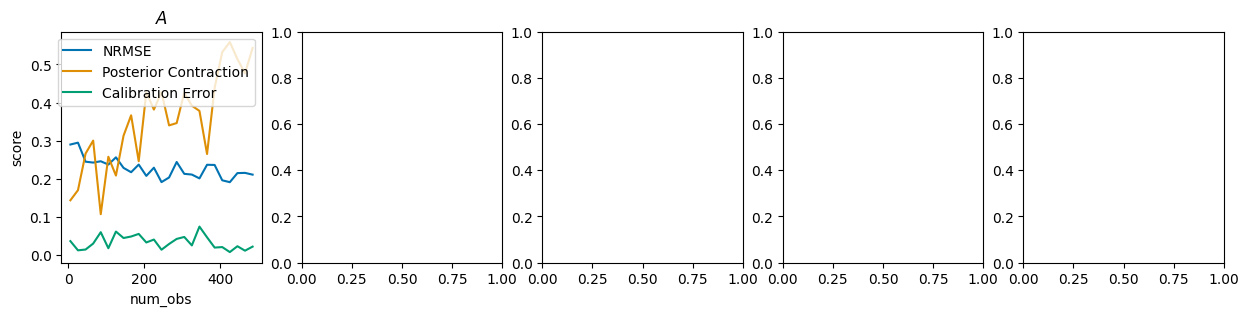

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns

param_names =  ["A", "tau", "mu_c", "mu_r", "b"]

fig, axes = plt.subplots(1,5, figsize=(15,3))

for p, ax in zip(param_names, axes):
    
    suff = "$\\" if p in ["tau", "mu_c", "mu_r"] else "$"

    label = suff + p + "$"
    
    sns.lineplot(data_metrics_long[data_metrics_long["parameter"] == p], x="num_obs", y="score", hue="metric", ax=ax, palette="colorblind")
    ax.set_title(label)
    ax.legend(title="")
    ax.set_
    if p != "b":
        ax.get_legend().remove()

fig.tight_layout()
# sns.lineplot(data_metrics_long, x="num_obs", y ="score", col="parameter")

In [42]:
metrics_table["n_obs"] = 10

metrics_table

A       tau      mu_c      mu_r         b  n_obs
NRMSE                  0.282219  0.284907  0.162782  0.110885  0.136611     10
Posterior Contraction  0.198050  0.025385  0.719526  0.874438  0.799351     10
Calibration Error      0.011974  0.013421  0.116974  0.102763  0.081447     10